<a href="https://colab.research.google.com/github/FranciscaAlliende/APS-Failure-at-Scania-Trucks/blob/master/ScaniaTrucks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#APS Failure at Scania Trucks

The dataset consists of data collected from heavy Scania trucks in everyday usage. The system in focus is the Air Pressure system (APS) which generates pressurized air that is utilized in various functions in a truck, such as braking and gear changes.

The datasets' positive class consists of component failures for a specific component of the APS system. The negative class consists of trucks with failures for components not related to the APS. The data consists of a subset of all available data, selected by experts.

In [1]:
# setup
from google.colab import drive
drive.mount("/content/drive")
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import basic_prepro as bp
import null_values as nv
import unbalanced_classes as uc
import dim_reduction as dr

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data exploration


In [2]:
# import data
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_training_set.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_test_set.csv')

In [3]:
print('Number of data points in the training set', train.shape[0])
print('Number of features in the training set', train.shape[1])

Number of data points in the training set 60000
Number of features in the training set 171


In [4]:
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [5]:
print('Number of data points in the test dataset', test.shape[0])
print('Number of features in the test dataset', test.shape[1])

Number of data points in the test dataset 16000
Number of features in the test dataset 171


In [6]:
test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,2682,4736,3862,1846,0,0,0,3976,0,0,0,1520,2374,11516,9480,111258,470,0,0,0,0,58,26,0,0,0,0,0,0,0,...,0,6598,70,112,0,0,0,0,0,0,0,0,340,0,0,1100,574,232,66,780,882,0,4,0,0,0,465.5,90,7502,3156,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,0,748,12594,3636,0,0,0,5244,0,60,0,0,0,23174,18166,23686,1270,0,0,0,0,12,82,0,0,0,0,0,0,0,...,0,7918,78,40,0,0,0,0,0,0,0,0,352,0,0,3996,584,200,62,37580,3756,6368,36,0,0,0,2.86,102,10040,3310,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,199486,1358536,1952422,452706,25130,520,0,1891670,0,0,0,77898,110548,3605894,3291610,959756,286536,0,0,0,0,106,340,0,0,0,0,0,24286,681260,...,0,3613906,4218,692,0,0,0,0,0,0,0,0,25278,9438,2504,10262714,1278664,109700,19072,9520,4902,4434614,70900,0,0,26002880,2057.84,2158,396312,538136,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,0,123922,984314,1680050,1135268,92606,14038,1772828,0,0,0,1116,2372,3546760,3053176,652616,423374,0,0,7274,0,1622,432,0,0,0,0,0,6388,1091104,...,46,3413978,2924,414,0,0,60,38710,0,0,0,0,27740,33354,6330,0,0,133542,21290,2718360,435370,0,0,0,0,1179900,1541.32,1678,659550,691580,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,na,156,140,0,0,0,0,0,0,72,17926,82834,3114,0,0,48978,0,0,0,0,0,97146,89920,12932,5092,0,0,0,0,102,50,0,0,0,0,0,11544,73570,...,0,95372,78,36,0,0,0,0,0,0,0,0,538,360,142,0,0,1822,344,2140,394,13664,110,0,0,813740,113.86,52,10216,9958,7646,4144,18466,49782,3176,482,76,0,0,0


In [7]:
classes_train = train["class"].value_counts()
classes_train

neg    59000
pos     1000
Name: class, dtype: int64

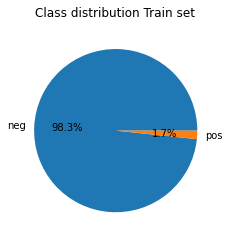

In [8]:
labels = 'neg', 'pos'
sizes = [list(classes_train)[0], list(classes_train)[1]]

fig = plt.figure(figsize=(5,3))
ax = fig.add_axes((0,0,.5,1))
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  

plt.title('Class distribution Train set')

plt.show()

In [9]:
classes_test = test["class"].value_counts()
classes_test

neg    15625
pos      375
Name: class, dtype: int64

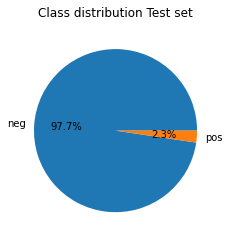

In [10]:
labels = 'neg', 'pos'
sizes = [list(classes_test)[0], list(classes_test)[1]]

fig = plt.figure(figsize=(5,3))
ax = fig.add_axes((0,0,.5,1))
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal') 

plt.title('Class distribution Test set')

plt.show()

In [11]:
# Null values
T1 = train
T2 = test
T1.replace(to_replace=['na','nan'],value = np.NaN,inplace=True)
T2.replace(to_replace=['na','nan'],value = np.NaN,inplace=True)

In [12]:
print("Total number of null values in the training set", T1.isnull().sum().sum())
print("Total number of null values in the test set", T2.isnull().sum().sum())

Total number of null values in the training set 850015
Total number of null values in the test set 228680


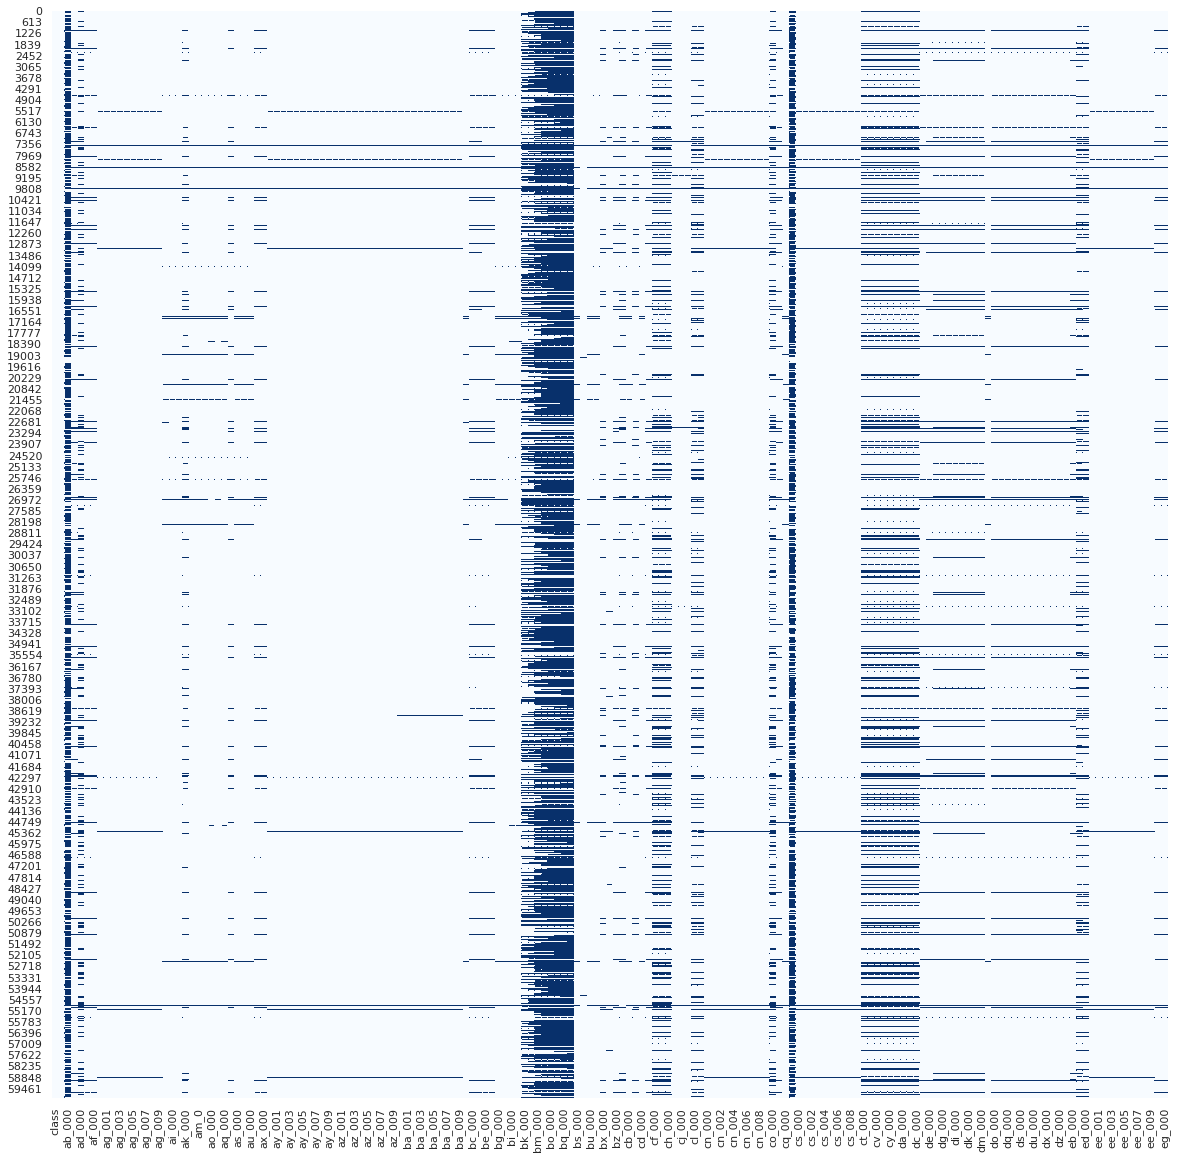

In [13]:
# Distribution null values train set (blue = null value)
sns.set(rc={'figure.figsize':(20,20)})
plot = sns.heatmap(T1.isnull(), cbar=False, cmap="Blues")
plt.show(plot)

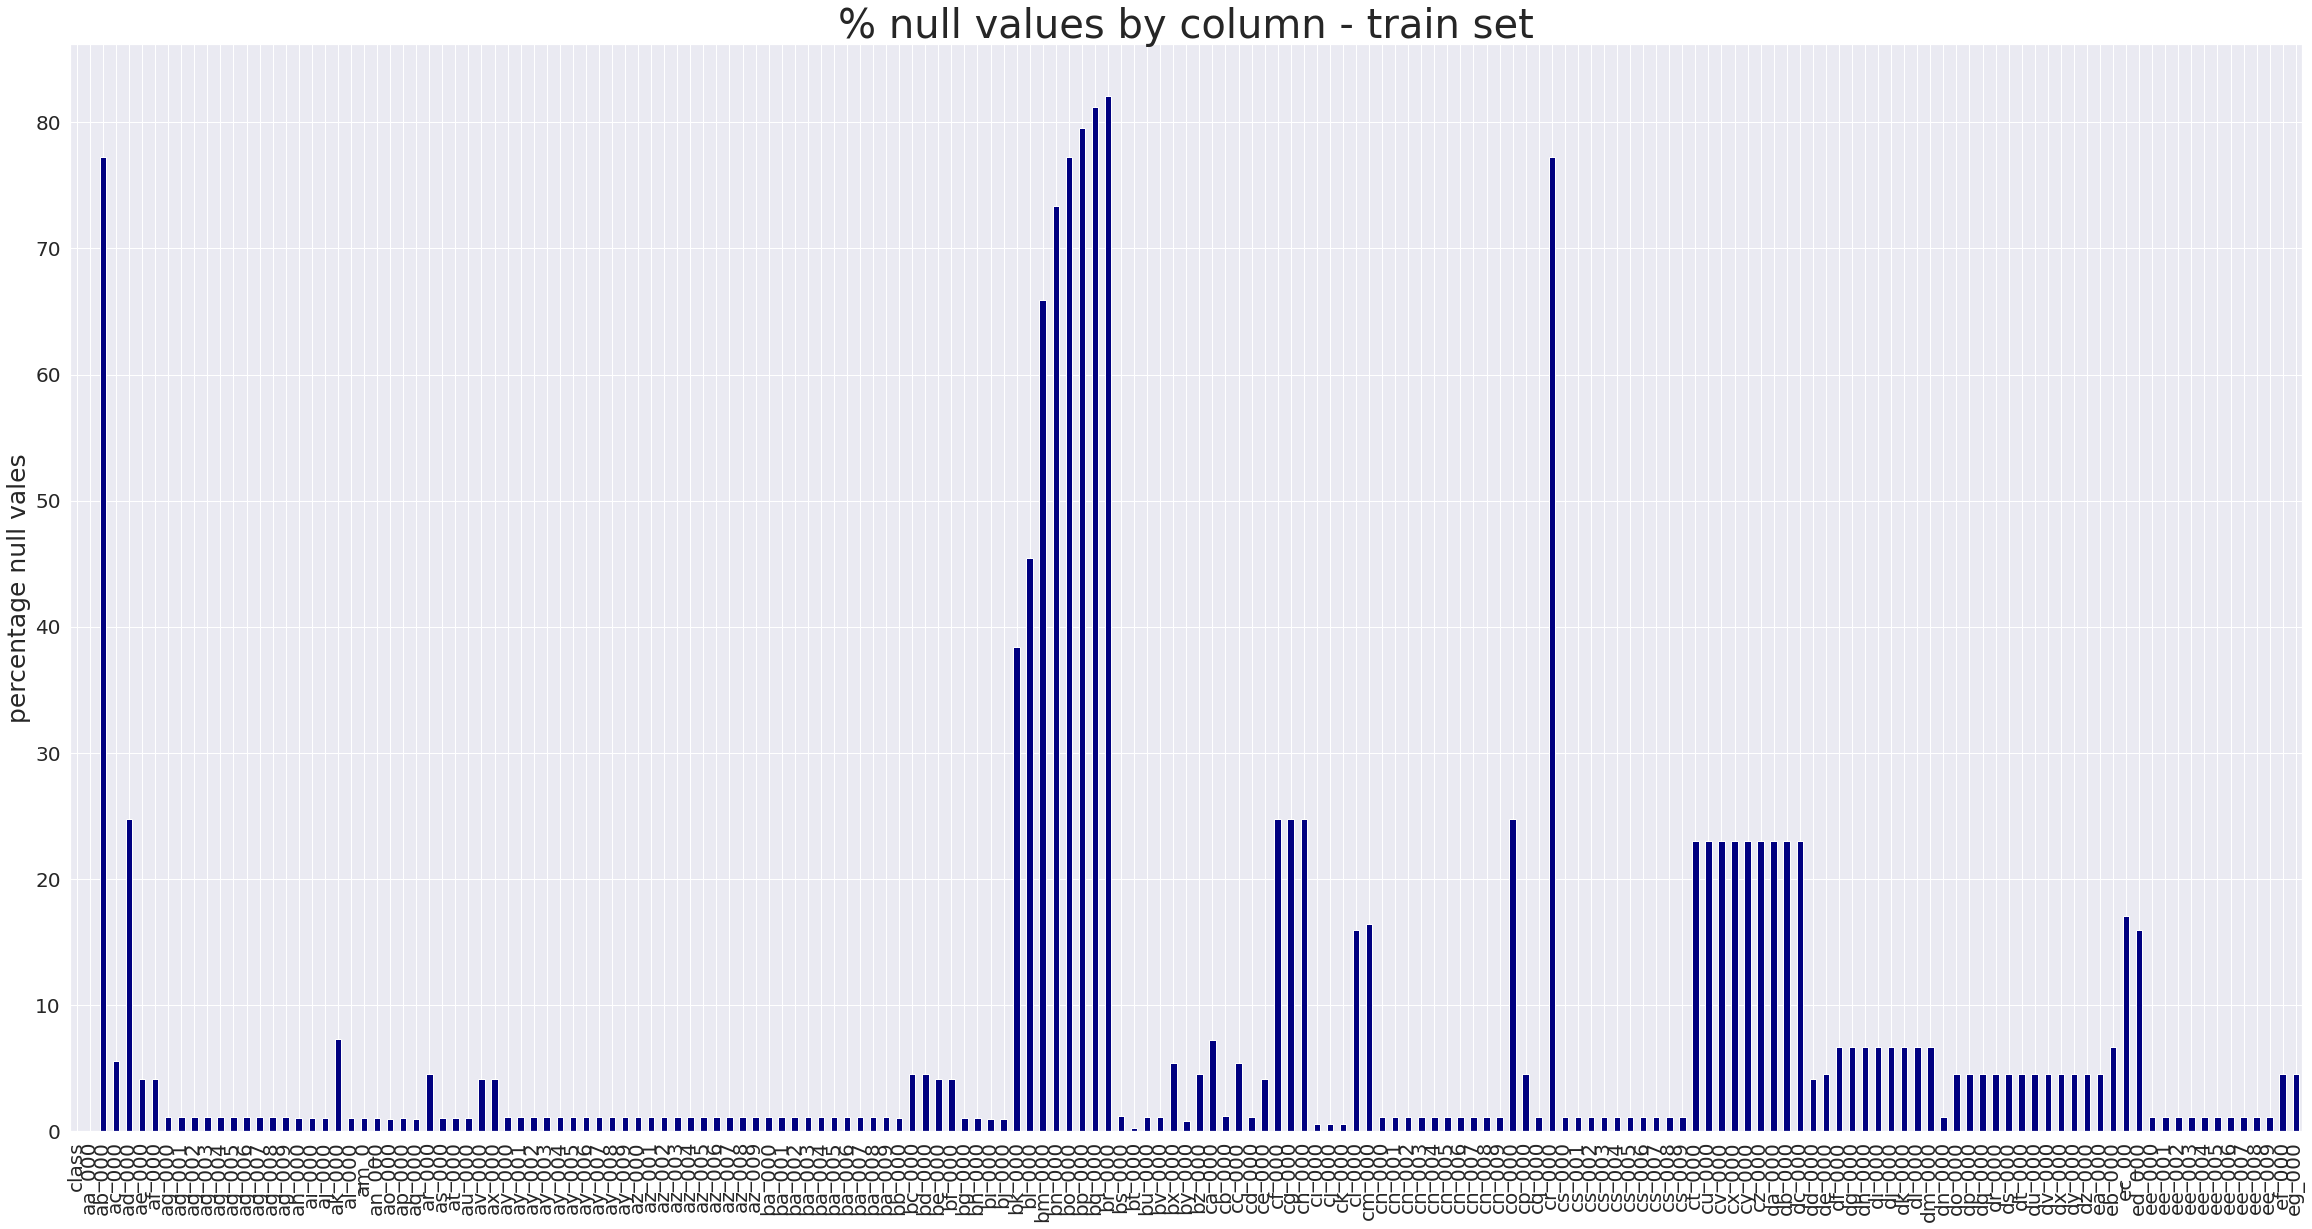

In [14]:
plt.figure()
data = T1.isnull().sum() * 100 / len(T1)
data.plot(kind="bar", colormap='jet', figsize=(40,20), fontsize=20 )
plt.title("% null values by column - train set", fontsize=40)
plt.ylabel('percentage null vales', fontsize=25)
plt.show()

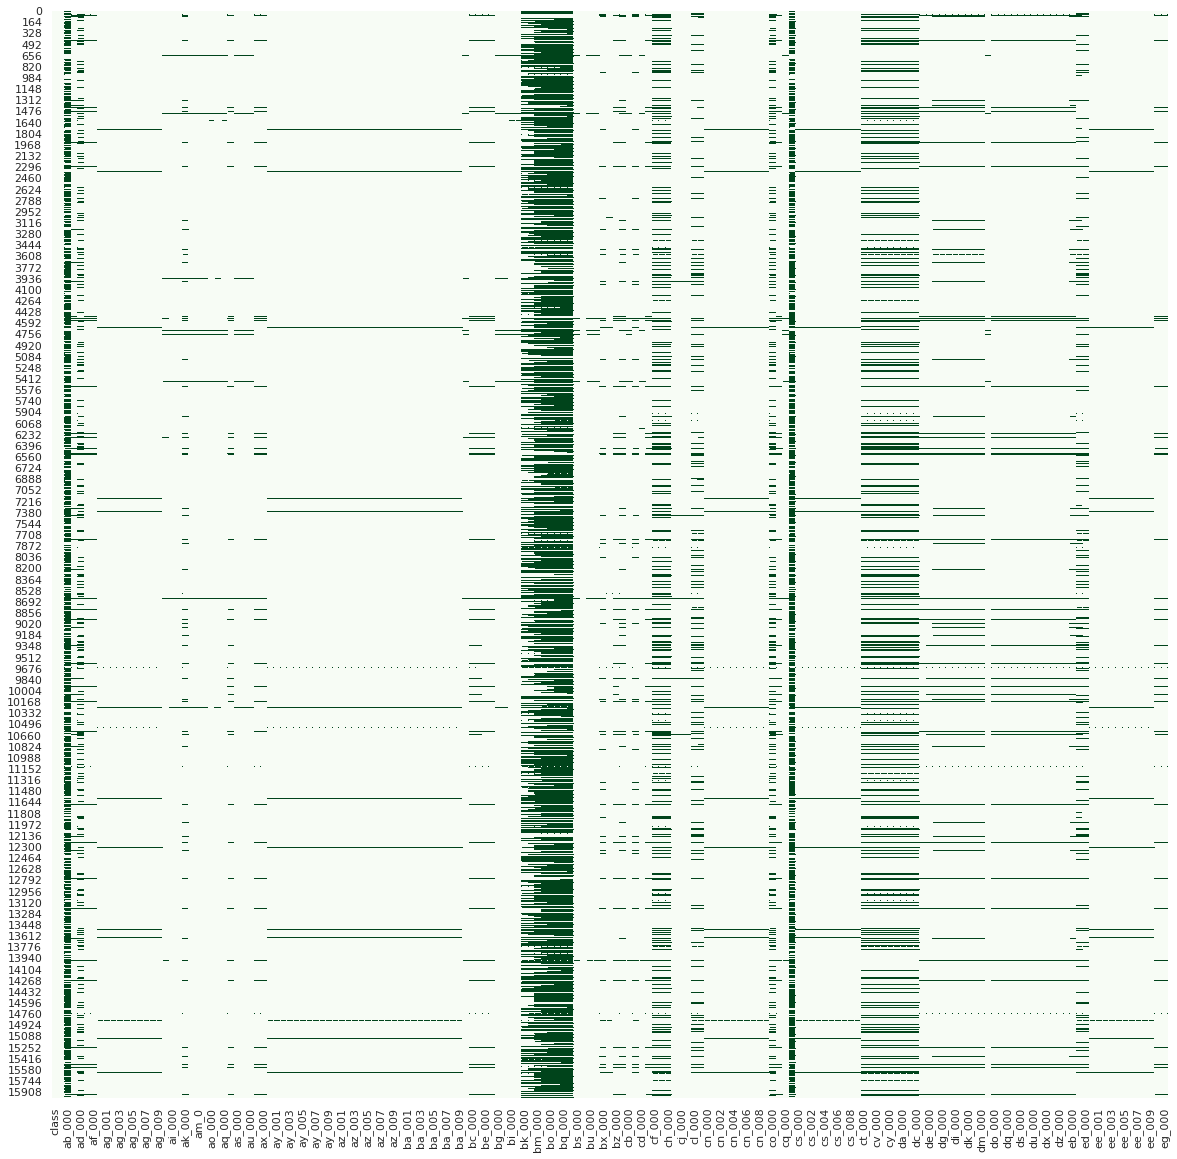

In [15]:
# Distribution null values test set (green = null value)
sns.set(rc={'figure.figsize':(20,20)})
plot = sns.heatmap(T2.isnull(), cbar=False, cmap="Greens")
plt.show(plot)

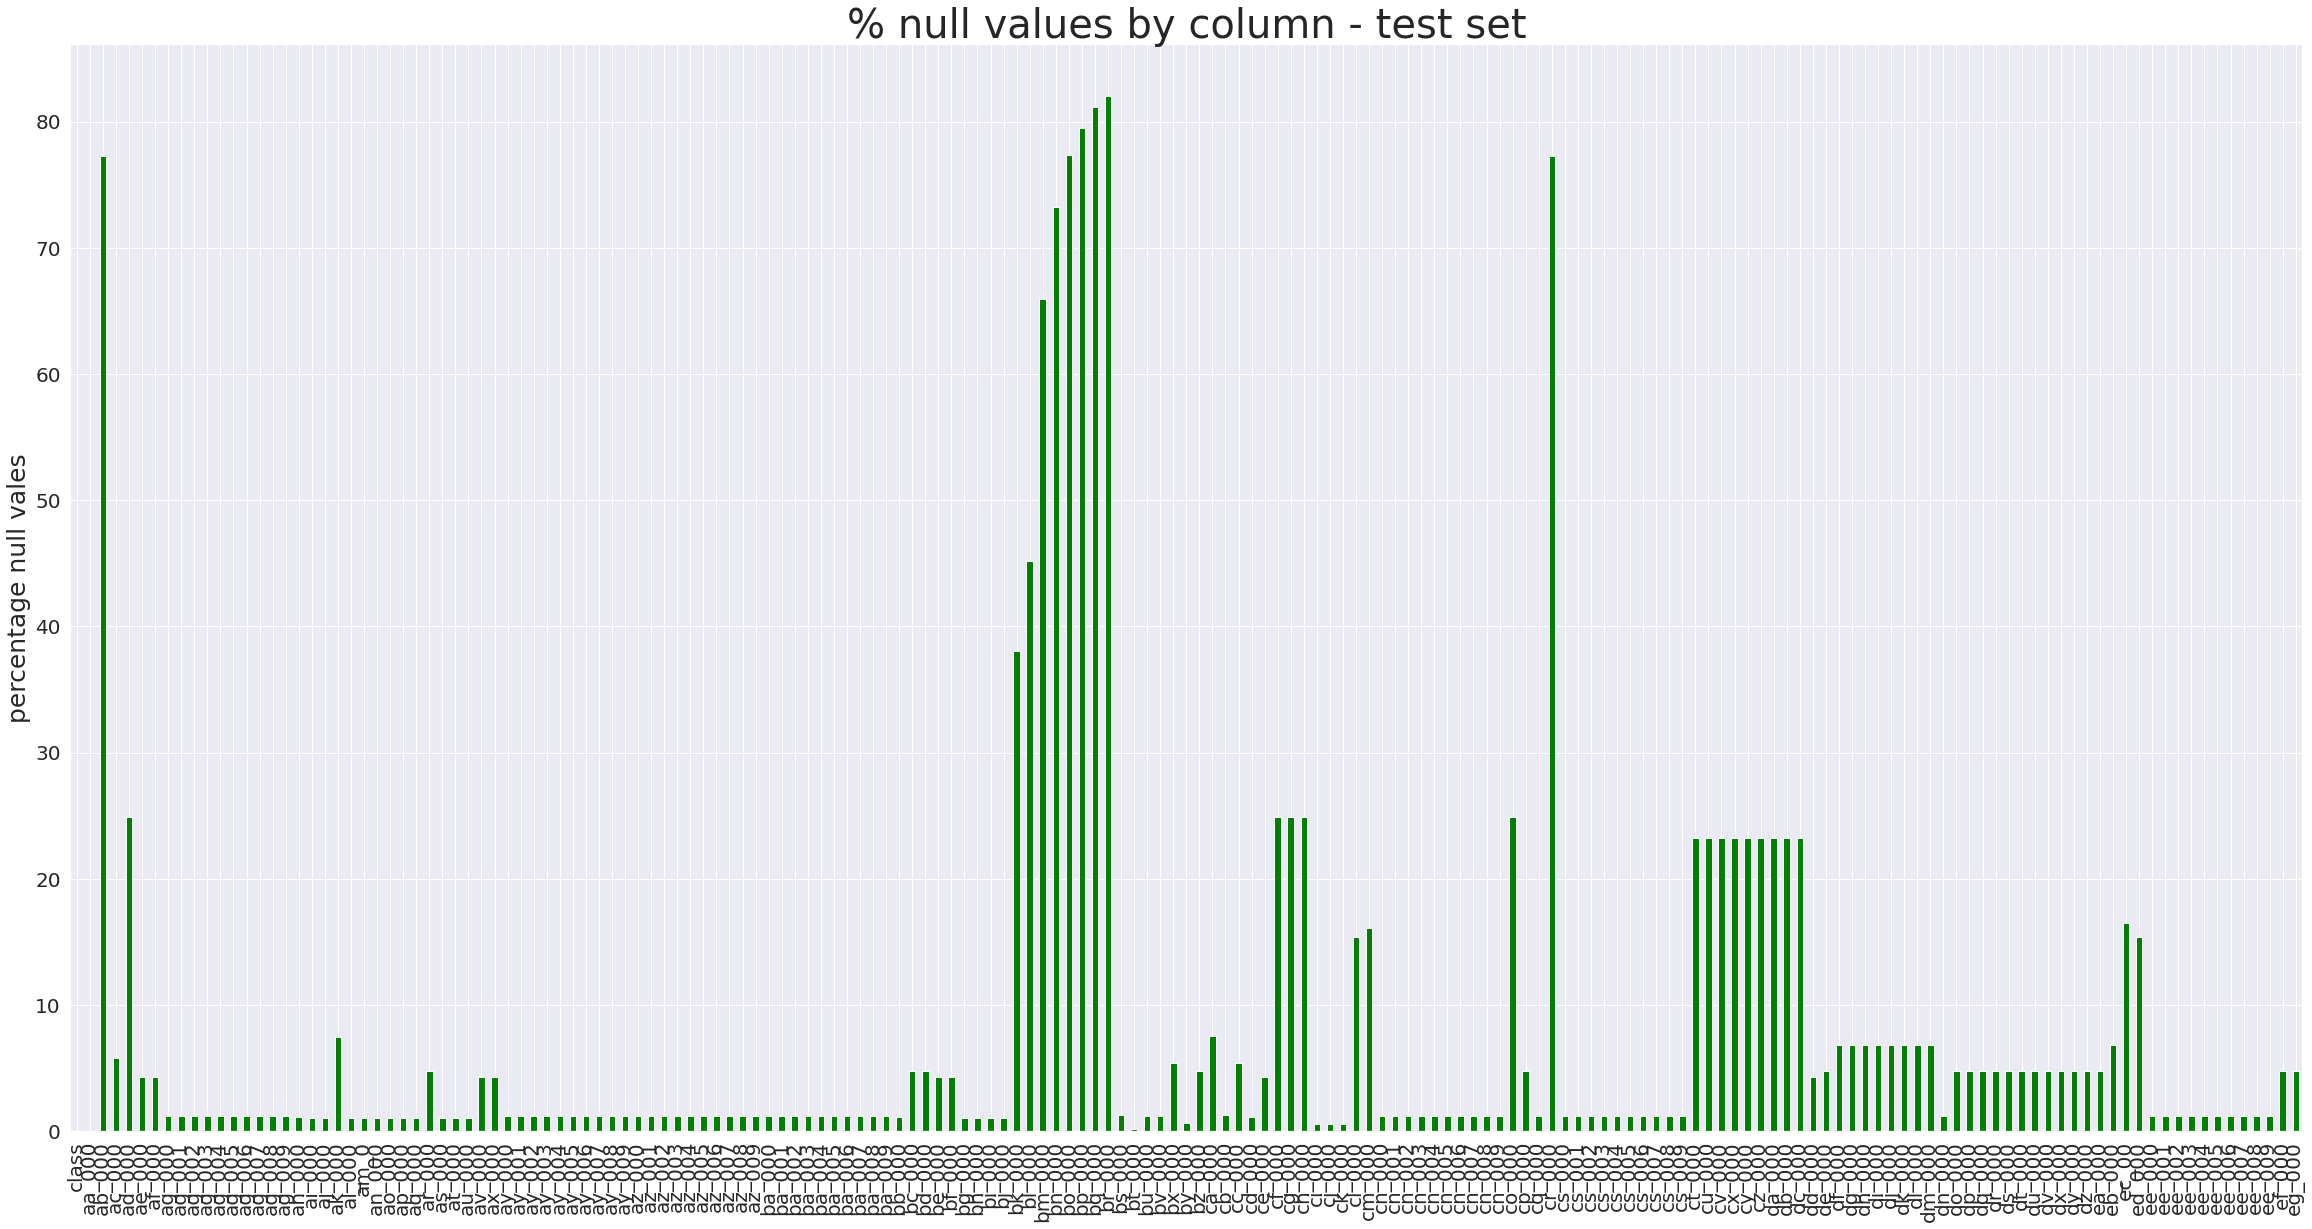

In [16]:
plt.figure()
data = T2.isnull().sum() * 100 / len(test)
data.plot(kind="bar", colormap='ocean', figsize=(40,20), fontsize=20 )
plt.title("% null values by column - test set", fontsize=40)
plt.ylabel('percentage null vales', fontsize=25)
plt.show()

## Pipeline


![](https://drive.google.com/uc?export=view&id=18kNVdAU2U_xiOz4AvYMXvkNHANrBs0z0) 

### Basic pre processing
- replace in class column: pos = 1; neg = 0
- replace the na and nan values with np.NaN

In [17]:
# basic prepocessing
train = bp.data_prepro(train)
test = bp.data_prepro(test)

### Null values

Giving the great number of null values, the features with more than t% of null values on the train-set were dropped. The remaining null values were filled with the median of the column using SimpleImputer from sklearn

In [18]:
# null values
[y_train, X_train, y_test, X_test] = nv.null_values(train, test, t=0.5)

### Unbalanced classes
In order to assess this issue, two methods where used: downsampling the majority class until reaching the minority class and upsampling the minority class creating synthetic data through SMOTE

#### Downsampling

In [19]:
# downsampling
[y_down_train, X_down_train] = uc.downsampling(y_train, X_train)

#### SMOTE

In [20]:
# upsampling
[y_up_train, X_up_train] = uc.mySMOTE(y_train, X_train, 100)

### Dimensionality reduction
Two methods were used for dimensionality reduction: Random Forest and PCA. In the RF method, the hyperparameter g was selected by analyzing the feature importance score graph. On the other hand, on the PCA method, the number of components was selected analyzing the explained variance.


#### Random Forest


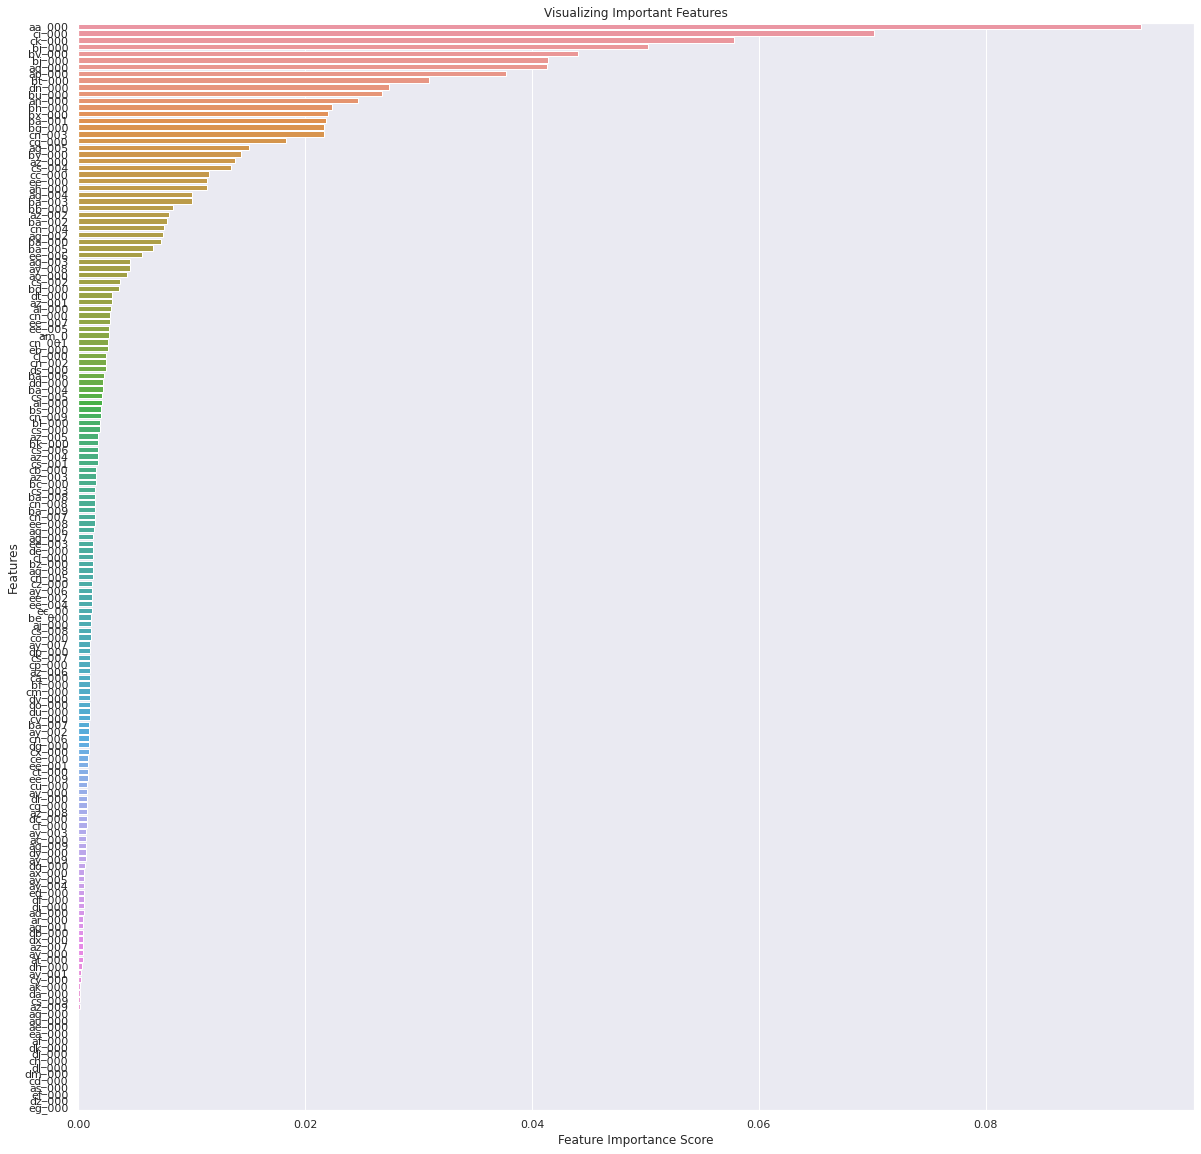

N selected features: 17


In [21]:
# dimensionality reduction RF + downsampling
[X_train_down_RF, X_test_down_RF] = dr.RF(X_down_train, y_down_train, X_test, n_estimators=100, g=0.02)

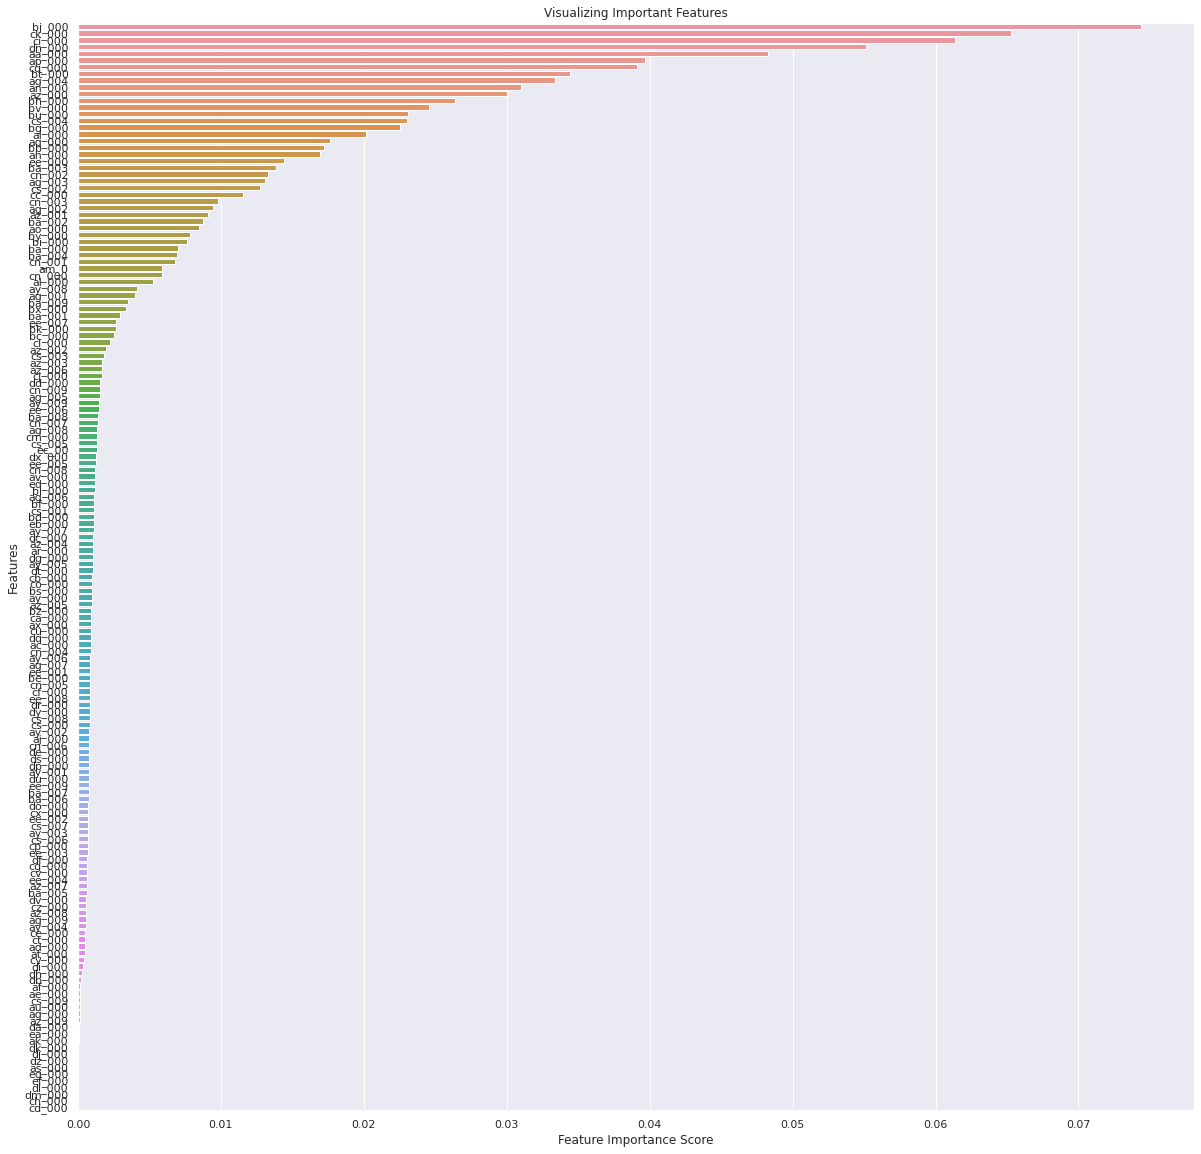

N selected features: 20


In [22]:
# dimensionality reduction RF + upsampling
[X_train_up_RF, X_test_up_RF] = dr.RF(X_up_train, y_up_train, X_test, n_estimators=100, g=0.015)

#### PCA

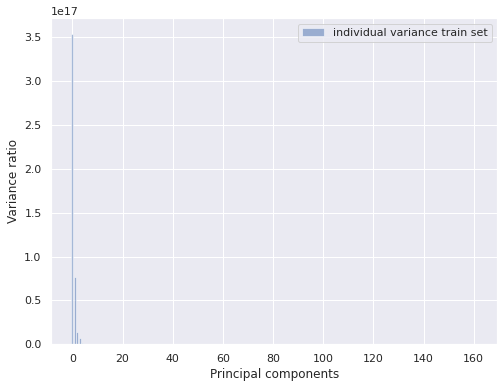

In [23]:
# dimensionality reduction PCA + downsampling
[X_train_down_PCA, X_test_down_PCA] = dr.myPCA(X_down_train, X_test, 10)

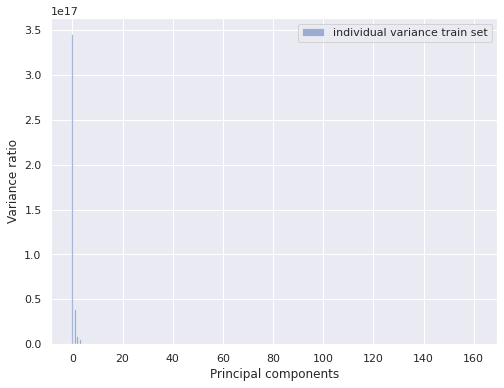

In [24]:
# dimensionality reduction PCA + upsampling
[X_train_up_PCA, X_test_up_PCA] = dr.myPCA(X_up_train, X_test, 10)

### Classification

#### SVM


In [25]:
from sklearn import svm
from sklearn import metrics

In [26]:
def mySVM(X_train, y_train, X_test, y_test):

  clf = svm.SVC()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred),3))

  print("Precision:", round(metrics.precision_score(y_test, y_pred), 3))

  print("Recall:", round(metrics.recall_score(y_test, y_pred)))

In [27]:
mySVM(X_train_down_RF,y_down_train, X_test_down_RF, y_test)

Accuracy: 0.95
Precision: 0.315
Recall: 1.0


In [28]:
mySVM(X_train_up_RF, y_up_train, X_test_up_RF, y_test)

Accuracy: 0.946
Precision: 0.299
Recall: 1.0


In [29]:
mySVM(X_train_down_PCA, y_down_train, X_test_down_PCA, y_test)

Accuracy: 0.961
Precision: 0.366
Recall: 1.0


In [30]:
mySVM(X_train_up_PCA, y_up_train, X_test_up_PCA, y_test)

Accuracy: 0.951
Precision: 0.316
Recall: 1.0


#### Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

In [54]:
def myLogit(X_train, y_train, X_test, y_test):
  clf = LogisticRegression()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred),3))

  print("Precision:", round(metrics.precision_score(y_test, y_pred), 3))

  print("Recall:", round(metrics.recall_score(y_test, y_pred)))

In [55]:
 myLogit(X_train_down_RF,y_down_train, X_test_down_RF, y_test)

Accuracy: 0.184
Precision: 0.028
Recall: 1.0


In [56]:
 myLogit(X_train_up_RF, y_up_train, X_test_up_RF, y_test)

Accuracy: 0.301
Precision: 0.032
Recall: 1.0


In [57]:
 myLogit(X_train_down_PCA, y_down_train, X_test_down_PCA, y_test)

Accuracy: 0.97
Precision: 0.427
Recall: 1.0


In [58]:
 myLogit(X_train_up_PCA, y_up_train, X_test_up_PCA, y_test)

Accuracy: 0.96
Precision: 0.36
Recall: 1.0


#### XGBoost

In [59]:
import xgboost as xgb

In [70]:
def myXGBoost(X_train, y_train, X_test, y_test):

  xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
  xg_reg.fit(X_train,y_train)
  y_pred = xg_reg.predict(X_test)
  y_pred = [round(value) for value in y_pred]
  
  print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred),3))

  print("Precision:", round(metrics.precision_score(y_test, y_pred), 3))

  print("Recall:", round(metrics.recall_score(y_test, y_pred)))

In [71]:
myXGBoost(X_train_down_RF,y_down_train, X_test_down_RF, y_test)

Accuracy: 0.939
Precision: 0.274
Recall: 1.0


In [72]:
myXGBoost(X_train_up_RF, y_up_train, X_test_up_RF, y_test)

Accuracy: 0.953
Precision: 0.326
Recall: 1.0


In [73]:
myXGBoost(X_train_down_PCA, y_down_train, X_test_down_PCA, y_test)

Accuracy: 0.936
Precision: 0.264
Recall: 1.0


In [74]:
myXGBoost(X_train_up_PCA, y_up_train, X_test_up_PCA, y_test)

Accuracy: 0.936
Precision: 0.265
Recall: 1.0


### Cost definition
Our goal is to minimize the cost associated with:
1. Unnecessary checks done by mechanic - \$10
2. Missing a faulty truck, which may cause breakdown \$500 

Note that unnecessary checks are represented by false positives, while having the breakdown of the truck represents a false negatives.





### Model comparison


### Sensitivity analysis on costs
